In [1]:
import ipyparallel as ipp
n = 4
rc = ipp.Cluster(engines="mpi", n=n).start_and_connect_sync()
view = rc[:]
rc.ids

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

[0, 1, 2, 3]

In [22]:
%%px --block
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpi4py import MPI
import copy
import sys
sys.path.append('../../../Decentralized-FL-Framework')
from communication import DecentralizedNoModelSGD
from comm_weights import flatten_weights, unflatten_weights
from network import Graph


np.random.seed(482)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
size = mpi.size
print("MPI rank: %i/%i" % (mpi.rank, mpi.size))

[stdout:0] MPI rank: 0/4


[stdout:2] MPI rank: 2/4


[stdout:1] MPI rank: 1/4


[stdout:3] MPI rank: 3/4


## Helper Functions

In [23]:
%%px --block
# Implement Custom Loss Function
@tf.function
def consensus_loss(y_true, y_pred, z, l2):
    
    # local error
    local_loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    # consensus error
    consensus_loss = l2*tf.keras.losses.CategoricalCrossentropy()(z, y_pred)
        
    return local_loss + consensus_loss

In [24]:
 %%px --block
# Play around with this more
def set_learning_rate(optimizer, epoch):
    if epoch >= 1:
        optimizer.lr = optimizer.lr * tf.math.exp(-0.1)

In [25]:
%%px --block
def average_models(model, local_update, layer_shapes, layer_sizes):
    model_weights = model.get_weights()
    # flatten tensor weights
    coordinate_weights = flatten_weights(model_weights)
    local_weights = flatten_weights(local_update)
    next_weights = unflatten_weights(np.average([coordinate_weights, local_weights], axis=0),
                                           layer_shapes, layer_sizes)
    # update model weights to average
    model.set_weights(next_weights)

In [26]:
%%px --block
def get_model_architecture(model):
    # find shape and total elements for each layer of the resnet model
    model_weights = model.get_weights()
    layer_shapes = []
    layer_sizes = []
    for i in range(len(model_weights)):
        layer_shapes.append(model_weights[i].shape)
        layer_sizes.append(model_weights[i].size)
    return layer_shapes, layer_sizes

In [ ]:
%%px --block

def data_pre_process(rank, size, train_pct, train_bs, test_bs, coordination_size, coord_bs):

    # read in CSV data
    raw_df_data = pd.read_csv("Data/Darknet.CSV", parse_dates=["Timestamp"], on_bad_lines='skip')

    # make timestamp numeric (just time of day)
    timestamp = raw_df_data["Timestamp"]
    raw_df_data["Timestamp"] = timestamp.dt.hour + timestamp.dt.minute/60 + timestamp.dt.second/3600

    # remove NaN rows and Inf
    raw_df = raw_df_data.replace([np.inf, -np.inf], np.nan)
    raw_df.dropna(inplace=True)

    # clean up the sub-labels (incorrectly labeled)
    raw_df.loc[raw_df['Label.1']=='AUDIO-STREAMING', 'Label.1'] = 'Audio-Streaming'
    raw_df.loc[raw_df['Label.1']=='AUDIO-STREAMING', 'Label.1'] = 'Audio-Streaming'
    raw_df.loc[raw_df['Label.1']=='Video-streaming', 'Label.1'] = 'Video-Streaming'
    raw_df.rename(columns = {"Label.1" : "Subtype"}, inplace = True)

    # add one-hot encoding of the sub-labels
    onehot = pd.get_dummies(raw_df['Subtype'])
    raw_df = pd.concat([raw_df, onehot], axis=1, join='inner')

    # drop IP columns and 0 columns
    ip_cols = ['Flow ID', 'Src IP', 'Dst IP', 'Active Mean', 'Active Std', 'Active Max', 
               'Active Min', 'Subflow Bwd Packets', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 
               'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'URG Flag Count', 'CWE Flag Count', 
               'ECE Flag Count', 'Bwd PSH Flags', 'Fwd URG Flags','Bwd URG Flags']
    raw_df.drop(ip_cols, axis=1, inplace=True)

    # label dataframe
    traffic_categories = raw_df['Label'].unique()
    tc = dict(zip(traffic_categories, range(len(traffic_categories))))
    class_attack = raw_df.Label.map(lambda a: tc[a])
    raw_df['Label'] = class_attack

    # shuffle dataset
    raw_df = raw_df.sample(frac=1)

    # extract features
    non_normalized_df = raw_df.drop(['Label', 'Subtype'], axis=1)

    # extract labels
    labels = raw_df['Label']

    # normalize the feature dataframe
    normalized_df = non_normalized_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    # create coordination set
    coord_x = tf.convert_to_tensor(normalized_df.iloc[:coordination_size,:])
    coord_y = tf.convert_to_tensor(labels[:coordination_size])
    coordination_set = tf.data.Dataset.from_tensor_slices((coord_x,coord_y)).batch(coord_bs)

    # get data info
    num_inputs = len(normalized_df.columns.to_list())
    num_outputs = len(traffic_categories)
    
    # Split training data amongst workers
    worker_data = np.array_split(normalized_df.iloc[coordination_size:,:], size)[rank]
    worker_label = np.array_split(labels[coordination_size:], size)[rank]
    
    # create train/test split
    num_data = len(worker_label)
    num_train =  int(num_data * train_pct)
    # train
    train_x = tf.convert_to_tensor(worker_data.iloc[:num_train,:])
    train_y = tf.convert_to_tensor(worker_label[:num_train])
    train_set = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(train_bs)
    # test
    test_x = tf.convert_to_tensor(worker_data.iloc[num_train:,:])
    test_y = tf.convert_to_tensor(worker_label[num_train:])
    test_set = tf.data.Dataset.from_tensor_slices((test_x,test_y)).batch(test_bs)
    
    # full training set
    # full_train_data = tf.convert_to_tensor(normalized_df)
    # full_train_label = tf.convert_to_tensor(labels)
    
    # non-iid Dataset
    # create train/test split
    nid_num_data = len(labels[coordination_size:])
    nid_num_train = int(nid_num_data * train_pct)
    normalized_df['Label'] = labels
    
    # Skew Non-IID
    nid_test_df = normalized_df[(coordination_size+nid_num_train):]
    test_labels = nid_test_df['Label']
    skew_df_sort = normalized_df[coordination_size:(coordination_size+nid_num_train)].sort_values(by=['Label'])
    nid_labels = skew_df_sort['Label']
    skew_df_sort = skew_df_sort.drop(['Label'], axis=1)
    nid_test_df = nid_test_df.drop(['Label'], axis=1)
    nid_worker_data = np.array_split(skew_df_sort, size)[rank]
    nid_worker_label = np.array_split(nid_labels, size)[rank]
    
    # Non-IID train
    nid_train_x = tf.convert_to_tensor(nid_worker_data)
    nid_train_y = tf.convert_to_tensor(nid_worker_label)
    nid_train_set = tf.data.Dataset.from_tensor_slices((nid_train_x, nid_train_y)).batch(train_bs)
    # Non-IID test
    nid_test_x = tf.convert_to_tensor(nid_test_df)
    nid_test_y = tf.convert_to_tensor(test_labels)
    
    return train_set, test_set, coordination_set, nid_train_set, nid_test_x, nid_test_y, num_inputs, num_outputs # full_train_data, full_train_label

In [ ]:
%%px --block
def train(model, lossF, optimizer, train_dataset, epochs):

    acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
        
    for epoch in range(epochs):
        
        # Adjust learning rate
        set_learning_rate(optimizer, epoch)

        # Local Training
        for batch_idx, (data, target) in enumerate(train_dataset):

            # Minibatch Update
            with tf.GradientTape() as tape:
                y_p = model(data, training=True)
                loss_val = lossF(y_true=target, y_pred=y_p)
            grads = tape.gradient(loss_val, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            acc_metric.update_state(target, y_p)
            loss_metric.update_state(target, y_p)
        
        print('(Rank %d) Epoch %d: Training Accuracy is %0.4f, Loss is %0.4f' % (rank, epoch+1, acc_metric.result(), loss_metric.result()))
        loss_metric.reset_states()
        acc_metric.reset_states()

In [ ]:
%%px --block
def middle_train(model, communicator, rank, size, lossF, optimizer, train_dataset, coordination_dataset, epochs, 
          coord_batch_size, batches, num_outputs, layer_shapes, layer_sizes, l2):

    acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
        
    for epoch in range(epochs):
        
        # Adjust learning rate
        set_learning_rate(optimizer, epoch)

        # Local Training
        for batch_idx, (data, target) in enumerate(train_dataset):
            
            # Forward Pass of Coordination Set (get z)
            send_predicted = np.zeros((num_outputs*coord_batch_size, batches), dtype=np.float32)
            for c_batch_idx, (c_data, c_target) in enumerate(coordination_dataset):
                pred = model(c_data, training=True)
                send_predicted[:, c_batch_idx] = pred.numpy().flatten()

            # Communication Process Here
            recv_avg_pred, comm_time = communicator.average(send_predicted)

            # save pre-batch model
            start_model = copy.deepcopy(model.get_weights())

            # Minibatch Update
            with tf.GradientTape() as tape:
                y_p = model(data, training=True)
                loss_val = lossF(y_true=target, y_pred=y_p)
            grads = tape.gradient(loss_val, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            acc_metric.update_state(target, y_p)
            loss_metric.update_state(target, y_p)

            # save model after batch
            local_model = copy.deepcopy(model.get_weights())

            # reset model weights
            model.set_weights(start_model)

            # Consensus Training
            for c_batch_idx, (c_data, c_target) in enumerate(coordination_dataset):
                with tf.GradientTape() as tape:
                    c_yp = model(c_data, training=True)
                    loss_val = consensus_loss(y_true=c_target, y_pred=c_yp,
                                               z=recv_avg_pred[:, c_batch_idx].reshape(coord_batch_size, num_outputs),
                                               l2=l2)
                grads = tape.gradient(loss_val, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # update model weights
            average_models(model, local_model, layer_shapes, layer_sizes)
        
        print('(Rank %d) Epoch %d: Training Accuracy is %0.4f, Loss is %0.4f' % (rank, epoch+1, acc_metric.result(), loss_metric.result()))
        loss_metric.reset_states()
        acc_metric.reset_states()

## Run Experiments

In [ ]:
%%px --block
train_pct = 0.8
train_bs = 128
test_bs = 128
coord_bs = 32**2
coordination_size = 32**2
coord_num_batches = int(np.ceil(coordination_size/coord_bs))

# preprocess and split data amongst workers
train_set, test_set, coord_set, nid_train_set, nid_test_x, nid_test_y, num_inputs, num_outputs = data_pre_process(rank, size, train_pct, train_bs, test_bs, coordination_size, coord_bs)

# add in coordination set for regular training
reg_train_set = nid_train_set.concatenate(nid_coord_set)



In [ ]:
%%px --block

# initialize graph
graph_type = 'fully-connected'
G = Graph(rank, size, mpi, graph_type, weight_type='uniform-symmetric', num_c=None)

# initialize communicator
communicator = DecentralizedNoModelSGD(rank, size, mpi, G)

In [ ]:
%%px --block

# normal train model
if rank == 0 or rank == 1:
    multi_model = tf.keras.Sequential()
    multi_model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(num_inputs,)))
    multi_model.add(tf.keras.layers.Dense(256, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(128, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(64, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(10, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(num_outputs, activation='softmax'))
else:
    multi_model = tf.keras.Sequential()
    multi_model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(num_inputs,)))
    multi_model.add(tf.keras.layers.Dense(128, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(256, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(128, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(64, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(10, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(num_outputs, activation='softmax'))

# Initialize Local Loss Function
lossF = tf.keras.losses.SparseCategoricalCrossentropy()

# model architecture
layer_shapes, layer_sizes = get_model_architecture(multi_model)

# l2 penalty
l2 = 0.1

# epochs
epochs = 10

# Initialize Optimizer
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Create MIDDLE model (same architecture and weights) for comparison
middle_model = tf.keras.models.clone_model(multi_model)

In [ ]:
%%px --block
# Regular training results
# train(multi_model, lossF, optimizer, train_set, epochs)
# non-iid train
train(multi_model, lossF, optimizer, reg_train_set, epochs)

In [ ]:
%%px --block
middle_train(middle_model, communicator, rank, size, lossF, optimizer, nid_train_set, 
      coord_set, epochs, coord_bs, coord_num_batches, num_outputs, layer_shapes, layer_sizes, l2)

In [ ]:
%%px --block
#reg_predictions = multi_model.predict(full_train_x)
#middle_predictions = middle_model.predict(full_train_x)
reg_predictions = multi_model.predict(nid_test_x)
middle_predictions = middle_model.predict(nid_test_x)

[output:2]

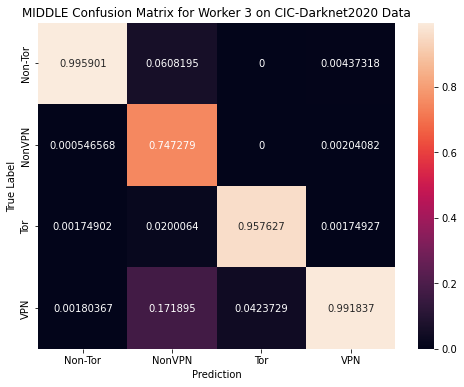

[output:1]

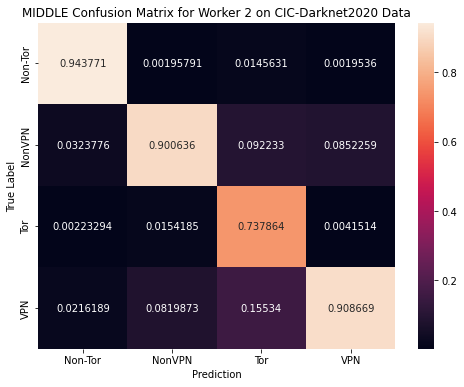

[output:3]

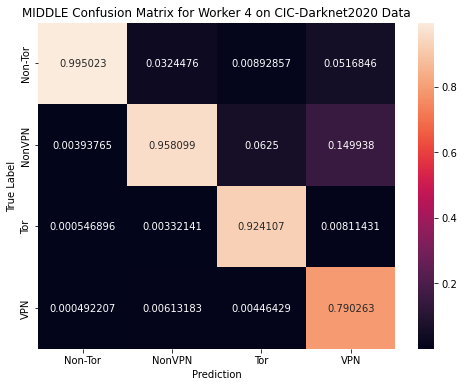

[output:0]

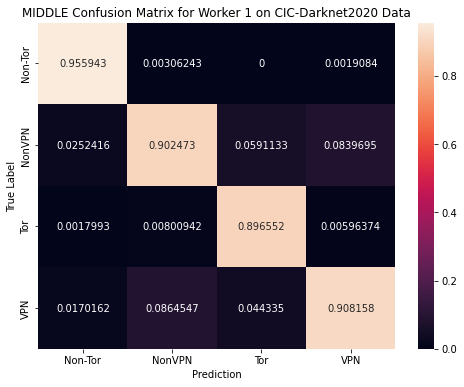

In [21]:
%%px --block
# MIDDLE Training Results
attack_labels = ['Non-Tor', 'NonVPN', 'Tor', 'VPN']
plt.figure(figsize=(8, 6))
sns.heatmap(middle_train_confusion_mtx,
            xticklabels=attack_labels,
            yticklabels=attack_labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('True Label')
plt.title('MIDDLE Confusion Matrix for Worker %d on CIC-Darknet2020 Data' % (rank+1))
plt.show()